In [1]:
import pandas as pd
from tqdm import tqdm
import requests
import urllib
import random
from multiprocessing import Pool
import matplotlib.pyplot as plt
from collections import Counter
import asyncio
import aiohttp
import urllib.parse
from random import sample
import difflib
import nltk
import multiprocessing
import numpy as np
from functools import partial
import os
import json

In [178]:
def metrix(results):
    count = 0
    count_1 = 0

    for result in results:
        last_char = result['find_stage'][-1]

        if last_char.isdigit():
            if int(last_char) > 0:
                count += 1
                
        if result['find_stage'] == 'not_found':
            count_1 += 1

    return count, count_1

# Utils

In [179]:
def create_histogram(data, label, title='Histogram', figsize=(20, 6),sort_by=''):
    
    find_stage_counts = Counter(elem.get(label, 'unknown')[:20] for elem in data if elem.get(label) is not None)

    for elem in data:
        if elem.get(label) is not None:
            elem.get(label)

    # Sort the keys alphabetically
    sorted_keys = sorted(find_stage_counts.keys())

    # Get the corresponding values in the same order as the sorted keys
    sorted_values = [find_stage_counts[key] for key in sorted_keys]

    # Plot the histogram
    fig, ax = plt.subplots(figsize=figsize)  # Increase the figure size
    #fig, ax = plt.subplots()
    #bars = ax.bar(find_stage_counts.keys(), find_stage_counts.values(), color='skyblue')
    if sort_by=='a':
        bars = ax.bar(sorted_keys, sorted_values, color='skyblue')
    else:
        bars = ax.bar(find_stage_counts.keys(), find_stage_counts.values(), color='skyblue')

    # Add the numbers on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    # Labels and formatting
    plt.xlabel(label)
    plt.ylabel('Number of Elements')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [180]:
def compare_strings(str1,str2):
    #return difflib.SequenceMatcher(None,str1,str2,False).ratio()
    return nltk.edit_distance(str1, str2)

In [181]:
def get_kingdom_query(string):
    if string=='Animalia':
        return 'higherTaxonKey=1&'
    elif string=='Archaea':
        return 'higherTaxonKey=2&'
    elif string=='Bacteria':
        return 'higherTaxonKey=3&'
    elif string=='Chromista':
        return 'higherTaxonKey=4&'
    elif string=='Fungi':
        return 'higherTaxonKey=5&'
    elif string=='Plants':
        return 'higherTaxonKey=6&'
    elif string=='Protozoa':
        return 'higherTaxonKey=7&'
    elif string=='Viruses_and_viroids':
        return 'higherTaxonKey=8&'
    else:
        #print(f'Kingdom: {string} not found')
        return ''

In [182]:
def get_kingdom_threshold(string):
    if string=='Animalia':
        return 2
    elif string=='Archaea':
        return 3
    elif string=='Bacteria':
        return 1
    elif string=='Chromista':
        return 3
    elif string=='Fungi':
        return 2
    elif string=='Plants':
        return 3
    elif string=='Protista':
        return 3
    elif string=='Viruses_and_viroids':
        return 1
    else:
        return 3
    


In [183]:
def divide_list(EPPO_names, num_processes):
    """Divides EPPO_names into nearly equal parts for multiprocessing without using numpy."""
    # Calculate the base block length
    block_len = len(EPPO_names) // num_processes
    # Calculate any extra items left after dividing evenly
    remainder = len(EPPO_names) % num_processes
    # Create the divided list
    EPPO_names_lists = []
    start = 0
    
    for i in range(num_processes):
        # Calculate the end index for each block
        end = start + block_len + (1 if i < remainder else 0)  # Add 1 to the first few blocks if remainder exists
        EPPO_names_lists.append(EPPO_names[start:end])
        start = end
    
    return EPPO_names_lists

In [184]:
def remove_last(name_list):
    to_remove = ['+','x', '×', 'var.','subvar.', 'subsp.', 'ssp.' , 'f.' ,'fo.', 'fa.']
    to_remove_micro = ['f.sp.' , 'pv.' , 'serovar', 'biovar']
    bad_suffix = ['sp.', 'hybrids', 'hybridus', '(s.l.)', 'sp,','cultivar', 'cultivars']
    result = []
    last=''
    for name in name_list:
        name=name.replace(' f. sp.',' f.sp.')
        parts = name.split()
        if parts[-1] in bad_suffix:
            last=parts.pop(-1)
        if len(parts)>2 and parts[-2] in to_remove + to_remove_micro:
            parts.pop(-2)
        if len(parts) > 1:  # Only add if there's more than one part
            if last:
                new_name = ' '.join(parts[:-1])+' '+last
            else:
                new_name = ' '.join(parts[:-1])
            new_name = new_name.replace(' f.sp.',' f. sp.')
            result.append(new_name)
            
    return result
            

In [185]:
to_remove = [' x ', ' × ', ' var. ', ' subsp. ' , ' f. ']
bad_suffix = [' sp.', ' hybrids', ' hybridus', ' (s.l.)', ' sp,']
def clean(string, to_remove):
    for substring in to_remove:
        string = string.replace(substring, ' ')
    if string.startswith('x ') or string.startswith('+ ') or string.startswith('× ') or string.startswith('+ '): 
        string = string[2:]
    for substring in bad_suffix:
        string = string.replace(substring, '')

    return string

# EPPO to GBIF (Plants)

In [186]:
df_EPPO = pd.read_parquet('/workdir/EPPO Dataframes/df.plants.scraped.sorted.gzip',engine='fastparquet')
df_EPPO.head(n=2)

,EPPO Code,Preferred name,Common names,Other scientific names,Associated Non-Taxonomic,Notes,Hosts,Pests,Images,Keys,Pathwayspests,Distribution,Pathwayshosts,Datasheet,Taxolink,Taxonomy Info,Authority
index,,,,,,,,,,,,,,,,,
32864,LYPES,Solanum lycopersicum,"[{'tomato': 'English'}, {'Liebesapfel': 'Germa...","[Lycopersicon esculentum, Lycopersicon lycoper...",{'fruiting solanaceous vegetable crops': '3FSVC'},"Native to South America (Northwest, probably o...",[],"{'ANSTLU': 'Experimental', 'AFCVD0': 'Experime...","[{'tag': [], 'url': 'https://gd.eppo.int/media...","[, pests, pathwayshosts, pathwayspests, report...","{'PYDV00': ['plants for planting'], 'PARZCO': ...",None,"{'TOBRFV': ['plants for planting', 'seeds', 'f...",None,/1PLAK/1MAGP/1ANGC/1LAMD/1SOLO/1SOLF/1SOLG/LYPES,"{'Kingdom': 'Plantae', 'Phylum': 'Magnoliophyt...",Linnaeus
10681,CIDSI,Citrus x aurantium var. sinensis,"[{'sweet orange': 'English'}, {'Apfelsine': 'G...","[Citrus aurantium var. sinensis, Citrus sinensis]",{'citrus fruit crops': '3CITC'},Hybrid. Native to China and Vietnam but no lon...,[],"{'PHYPPH': 'Doubtful host', 'CERTQU': 'Doubtfu...","[{'tag': [], 'url': 'https://gd.eppo.int/media...","[, pests, pathwayspests, photos, documents]","{'ALECSN': ['plants for planting', 'cut flower...",None,None,None,/1PLAK/1MAGP/1ANGC/1MAVD/1SAPO/1RUTF/1AURS/1CI...,"{'Kingdom': 'Plantae', 'Phylum': 'Magnoliophyt...",Linnaeus


In [187]:
# def fix_genus(row):
#     # Get the first word from 'Preferred name'
#     preferred_name = row['Preferred name']
#     other_scientific_names = row.get('Other scientific names', [])
    
#     names = [preferred_name] + other_scientific_names
    
#     genus = row['Taxonomy Info'].get('Genus', '')  # Extract the genus
#     if not genus:
#         return names + [genus]
    
#     number_of_words = len(genus.split())
    
#     new_names = []
#     for name in names:
#         name_words = name.split()
#         genus_part = ' '.join(name_words[:number_of_words])
#         if 1 <= compare_strings(genus_part, genus) < 5:     # Come Sesso e Samba
#             new_name = genus + ' ' + ' '.join(name_words[number_of_words:])
#             new_names.append(new_name)
    
#     return names + new_names + [genus]

def extract_row(row):
    # Get the first word from 'Preferred name'
    preferred_name = row['Preferred name']
    other_scientific_names = row.get('Other scientific names', [])
    EPPO_code = row.get('EPPO Code', '')
    
    names = [preferred_name] + other_scientific_names
    
    genus = row['Taxonomy Info'].get('Genus', '')  # Extract the genus
    if not genus:
        return EPPO_code, names + [genus]
    
    number_of_words = len(genus.split())
    
    new_names = []
    for name in names:
        name_words = name.split()
        genus_part = ' '.join(name_words[:number_of_words])
        if 1 <= compare_strings(genus_part, genus) < 5:     # TODO maybe lower threshold
            new_name = genus + ' ' + ' '.join(name_words[number_of_words:])
            new_names.append(new_name)
    
    return EPPO_code, names + new_names + [genus]


In [188]:
# RANKERS
# TODO implement threshold in methods
def best_rank_status(scientific_name,search_name, json_list, status_label, threshold=1):
    # get best matching result from quert response json base on a speficic order of taxon rank and rank status
    # scientific name is included for legacy
    
    ranks=['GENUS','SPECIES','SUBSPECIES','VARIETY','FORM']
    statuses=['ACCEPTED','SYNONYM','SYNONYMS','HOMOTYPIC_SYNONYM','HETEROTYPIC_SYNONYM','PROPARTE_SYNONYM','DOUBTFUL']
    for rank in ranks:
        for status in statuses:
            for i, elem in enumerate(json_list):
                elem_name = elem.get('canonicalName', elem.get('scientificName',''))
                if elem.get('rank') == rank and elem.get(status_label) == status and elem_name and compare_strings(search_name, elem_name) < threshold:
                        rank_s = elem.get('rank') + '_' + elem.get(status_label)
                        return {'GBIF_canonical_name': elem_name, 'rank_status': rank_s,  'rank': elem.get('rank'),'status' : elem.get(status_label), 'unique_id': elem['key'], 'result': elem}




                    
# def genus_rank(scientific_name,search_name, json_list, status_label, threshold=1):
#     # genus
#     statuses=['ACCEPTED','SYNONYM','SYNONYMS','HOMOTYPIC_SYNONYM','HETEROTYPIC_SYNONYM','PROPARTE_SYNONYM','DOUBTFUL']
#     for status in statuses:
#         for i, elem in enumerate(json_list):
#             elem_name = elem.get('canonicalName', elem.get('scientificName',''))
#             if elem.get('rank') == 'GENUS' and elem.get(status_label) == status and elem_name and compare_strings(search_name, elem_name) < threshold:
#                 return {'GBIF_canonical_name': elem_name, 'rank_status': f'GENUS_{status}', 'unique_id': elem['key']}
            
def similarity_rank(scientific_name,search_name, json_list, status_label, threshold=1):
    for i, elem in enumerate(json_list):
        elem_name = elem.get('canonicalName', elem.get('scientificName',''))
        if compare_strings(scientific_name, elem_name) < threshold:
            rank_status = f"{elem.get('rank')}_{elem.get(status_label)}"
            return {'GBIF_canonical_name': elem_name, 'rank_status': rank_status, 'rank': elem.get('rank'),'status' : elem.get(status_label), 'unique_id': elem['key'], 'result': elem}

# PREPROCESS

def mispell_fix(string):
    if len(string.split())>1:
        return [string[:-i] for i in range(1, len(string.split()[-1]))]
    else:
        return [string[:-i] for i in range(1, len(string.split()[-1]))]
    #return [string[:-i] for i in range(1, len(string) - len(string.split()[0]))]


def remove_locutions(string):
    to_remove = [' x ', ' × ', ' var. ', ' subsp. ' , ' f. ']
    to_remove_micro = [' f. sp. ' , ' pv. ' , ' serovar ', ' biovar ']
    for substring in to_remove_micro + to_remove:
        string = string.replace(substring, ' ')
    return string

def fix_hybrids(string):
    if ' × ' in string:
        parts=string.split(" × ")
        first_name=parts[0].split()
        if len(first_name)==2:
            return first_name[0]
        elif len(first_name)>2:
            return first_name[0]+' '+first_name[1]
    if ' + ' in string:
        parts=string.split(" + ")
        first_name=parts[0].split()
        if len(first_name)==2:
            return first_name[0]
        elif len(first_name)>2:
            return first_name[0]+' '+first_name[1]
    return string
    

# TODO could be improved by adapting thresholds for each method
def get_methods(kingdom):
    kingdom_query = get_kingdom_query(kingdom)
    kingdom_threshold = get_kingdom_threshold(kingdom)
    
    
    methods = {
        'suggest': {
        'url': 'https://api.gbif.org/v1/species/suggest?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&'+kingdom_query+'q={parsed_name}',
        'preprocess': lambda x : x,
        'status_label': 'status',
        'get_results': lambda x : x,
        'ranker': partial(best_rank_status, threshold=kingdom_threshold),
        'description': '',
        'suggest_mode': True,
        },
        'search': {
        'url': 'https://api.gbif.org/v1/species/search?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&'+kingdom_query+'q={parsed_name}',
        'preprocess': lambda x : x,
        'status_label': 'taxonomicStatus',
        'get_results': lambda x : x['results'],
        'ranker': partial(best_rank_status, threshold=kingdom_threshold),
        'description': '',
        'suggest_mode': False,
        },
        'suggest_no_loc': {
        'url': 'https://api.gbif.org/v1/species/suggest?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&'+kingdom_query+'q={parsed_name}',
        'preprocess': remove_locutions,
        'status_label': 'status',
        'get_results': lambda x : x,
        'ranker': partial(best_rank_status, threshold=kingdom_threshold),
        'description': '',
        'suggest_mode': True,
        },
        'search_no_loc': {
        'url': 'https://api.gbif.org/v1/species/search?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&'+kingdom_query+'q={parsed_name}',
        'preprocess': remove_locutions,
        'status_label': 'taxonomicStatus',
        'get_results': lambda x : x['results'],
        'ranker': partial(best_rank_status, threshold=kingdom_threshold),
        'description': '',
        'suggest_mode': False,
        },
        'mispell_suggest': 
        {
        'url': 'https://api.gbif.org/v1/species/suggest?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&'+kingdom_query+'q={parsed_name}',
        'preprocess': mispell_fix,
        'status_label': 'status',
        'get_results': lambda x : x,
        'ranker': partial(similarity_rank, threshold=kingdom_threshold),
        'description': '',
        'suggest_mode': True,
        },
        'fix_hybrids': {
        'url': 'https://api.gbif.org/v1/species/suggest?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&'+kingdom_query+'q={parsed_name}',
        'preprocess': fix_hybrids,
        'status_label': 'status',
        'get_results': lambda x : x,
        'ranker': partial(best_rank_status, threshold=kingdom_threshold),
        'description': '',
        'suggest_mode': True,
        },  
        'incertia': {
        'url': 'https://api.gbif.org/v1/species/suggest?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&higherTaxonKey=0&q={parsed_name}',
        'preprocess': lambda x : x,
        'status_label': 'status',
        'get_results': lambda x : x,
        'ranker': partial(best_rank_status, threshold=kingdom_threshold),
        'description': '',
        'suggest_mode': True,
        },
    }
    
    if kingdom=='Fungi':
        # FUNGI only
        methods.update({
        'protozoa': {
        'url': 'https://api.gbif.org/v1/species/suggest?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&higherTaxonKey=7&q={parsed_name}',
        'preprocess': lambda x : x,
        'status_label': 'status',
        'get_results': lambda x : x,
        'ranker': partial(best_rank_status, threshold=kingdom_threshold),
        'description': '',
        'suggest_mode': True,
        }
        }
        )
        
    return methods

In [189]:
def suggest_to_search(key, response_json):
    for elem in response_json:
        elem_key = elem.get('key')
        #print(int(elem_key), int(key))
        if int(elem_key) == int(key):
            result = {'result': elem}
            return result
        

async def get_speciesID_by_method(scientific_name, session, method_name, debug_mode = False, kingdom='plants'):
    # method_name is one of the keys of methods
    methods = get_methods(kingdom)
    method = methods[method_name]
    
    preprocess = method['preprocess']
    status_label = method['status_label']
    get_results = method['get_results']
    ranker = method.get('ranker', best_rank_status)
    
    prev = scientific_name
    # General string preprocess, irrespective of search method
    scientific_name = scientific_name.replace(' x ', ' × ')
    if scientific_name.startswith('x ') or scientific_name.startswith('+ ') or scientific_name.startswith('× '):
        scientific_name = scientific_name[2:]
    if 'Hybrid' in scientific_name.split():
        scientific_name=scientific_name.replace("Hybrid","")

    
    # DEBUG
    if not scientific_name:
        return {'GBIF_canonical_name': None, 'rank_status': None, 'unique_id': None, 'find_stage': method_name}
    
    bad_suffix = ['sp.', 'hybrids', 'hybridus', '(s.l.)', 'sp,', '(s.l.)','cultivar', 'cultivars']
    if scientific_name.split()[-1] in bad_suffix:
        scientific_name=' '.join(scientific_name.split()[:-1])
        method_name='bad_suffix'
    
    
    search_names = preprocess(scientific_name)
    
    
    if not isinstance(search_names, list):
        search_names = [search_names]   
        
    for search_name in search_names:
        parsed_name = urllib.parse.quote(search_name)
        url = method['url'].format(parsed_name=parsed_name)

        async with session.get(url) as response:
            # Use search name or scientific name?
            response_json = await response.json()
            #print(response_json)
            result_dict = ranker(scientific_name, search_name, get_results(response_json), status_label)
            if result_dict:
                result_dict.update({'find_stage': method_name})
                
                if not method['suggest_mode']:                
                    return result_dict
        if result_dict:
            #https://api.gbif.org/v1/species/search?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&rank=SPECIES&status=ACCEPTED&q=Prunus%20domestica
            name_for_search=result_dict.get("GBIF_canonical_name")
            rank=result_dict.get("rank")
            status=result_dict.get("status")
            url = f'https://api.gbif.org/v1/species/search?datasetKey=d7dddbf4-2cf0-4f39-9b2a-bb099caae36c&rank={rank}&status={status}&q={name_for_search}'#{result_dict.get("GBIF_canonical_name")}'       
            async with session.get(url) as response:
                # Use search name or scientific name?
                response_json = await response.json()
                extra_result = suggest_to_search(result_dict.get("unique_id"), response_json['results'])
                if extra_result:
                    result_dict.update(extra_result)
                else:
                    print(f'ERROR: input name: {search_name}, name for search: {result_dict.get("GBIF_canonical_name")}, key: {result_dict.get("unique_id")}')
                return result_dict
            
        
    if debug_mode:
        print(f'method: {method_name:<30} | scientific: {scientific_name:<30} | search: {str(search_names):<40}  | result: {"not found":<30}')
        
    return {'GBIF_canonical_name': None, 'rank_status': None, 'unique_id': None, 'find_stage': method_name}


In [190]:
async def get_speciesID(scientific_names, session, genus_name='',kingdom='plants', found_from = False, debug_mode=False):
    # Takes a list of scientific names (for the same organism) and returns the the best match from GBIF using a hierarchy of methods
    # if input single name
    if not isinstance(scientific_names, list):
        scientific_names = [scientific_names]
    iteration = 0
    original_names = [name for name in scientific_names]
    methods=get_methods(kingdom)
    while(scientific_names):        
        for method in methods:
            for original_name,scientific_name in zip(original_names,scientific_names):
                if not scientific_name:
                    print(original_names,scientific_names)
                result = await get_speciesID_by_method(scientific_name, session, method, debug_mode, kingdom=kingdom)
                if result['unique_id']:
                    if found_from:
                        result.update({'found_from': original_name, 'find_stage': result['find_stage']+'_'+str(iteration)})
                    return result
        iteration+=1
        scientific_names=remove_last(scientific_names)
    
    for method in methods:
        result = await get_speciesID_by_method(genus_name, session, method, debug_mode, kingdom=kingdom)
        if result['unique_id']:
            if found_from:
                result.update({'found_from': genus_name, 'find_stage': result['find_stage']+'_'+'genus'})
            return result
    
                
            
    return {'GBIF_canonical_name': None, 'rank_status': 'NOT_FOUND', 'unique_id': None, 'find_stage': 'not_found'}

async def get_speciesID_EPPO(scientific_names, session, index, EPPO_code, kingdom):
    # async wrapper for use in EPPO_to_GBIF
    genus_name=scientific_names.pop(-1)
    result = await get_speciesID(scientific_names, session, genus_name=genus_name, found_from = True, kingdom=kingdom)
    result.update({'EPPO_names': scientific_names+[genus_name], 'index': index, 'EPPO_code': EPPO_code})
    return result


async def async_get_speciesID_EPPO_batch(urls_list, kingdom):
    # batch version for get_speciesID_EPPO
    async with aiohttp.ClientSession() as session:
        tasks=[]
        for index, EPPO_code, scientific_names in urls_list:
            tasks.append(get_speciesID_EPPO(scientific_names, session, index, EPPO_code, kingdom=kingdom))
        
        # Use asyncio.gather to run all tasks in parallel
        results = await asyncio.gather(*tasks)
        return results


def sync_get_speciesID_EPPO_batch(urls_list, kingdom):
    # sync wrapper for async_get_speciesID_EPPO_batch
    return asyncio.run(async_get_speciesID_EPPO_batch(urls_list, kingdom=kingdom))

def EPPO_to_GBIF_parallel(eppo_path='/workdir/EPPO Dataframes/df.plants.scraped.sorted.gzip', num=-1,num_processes=4, with_images=False, random=False, kingdom='plants'):
    
    df_EPPO = pd.read_parquet(eppo_path, engine='fastparquet')
    if with_images:
        df_EPPO = df_EPPO[df_EPPO['Images'].notna()]
        
    
    # A list whose elements are lists of possible scientific names for a given organism, starting from preferred
    # assumes df_EPPO is sorted based on a specific ranking. TODO: update to include the ranking index rather than enumerate
    EPPO_entries = enumerate(list(df_EPPO.apply(extract_row, axis=1)))
    EPPO_entries = [(index, EPPO_code, EPPO_names) for index, (EPPO_code, EPPO_names) in EPPO_entries]

    if num < 0:
        EPPO_entries = EPPO_entries
    elif random:
        EPPO_entries = sample(EPPO_entries, num)
    else:
        EPPO_entries = EPPO_entries[:num]
    
    EPPO_entries_lists = divide_list(EPPO_entries, num_processes)
    
    get_speciesID_kingdom = partial(sync_get_speciesID_EPPO_batch, kingdom = kingdom)

    
    # Create a pool of worker processes
    with multiprocessing.Pool() as pool:
        # Use map to apply the function to each element in numbers list in parallel
        results = pool.map(get_speciesID_kingdom, EPPO_entries_lists)
    return sum(results, [])

In [191]:
async def EPPO_single(scientific_name, kingdom='plants'):

    async with aiohttp.ClientSession() as session:
        # Use asyncio.gather to run all tasks in parallel
        result = await get_speciesID([scientific_name], session, debug_mode=True, kingdom=kingdom )
    
    return result

# Results

In [110]:
results = EPPO_to_GBIF_parallel()

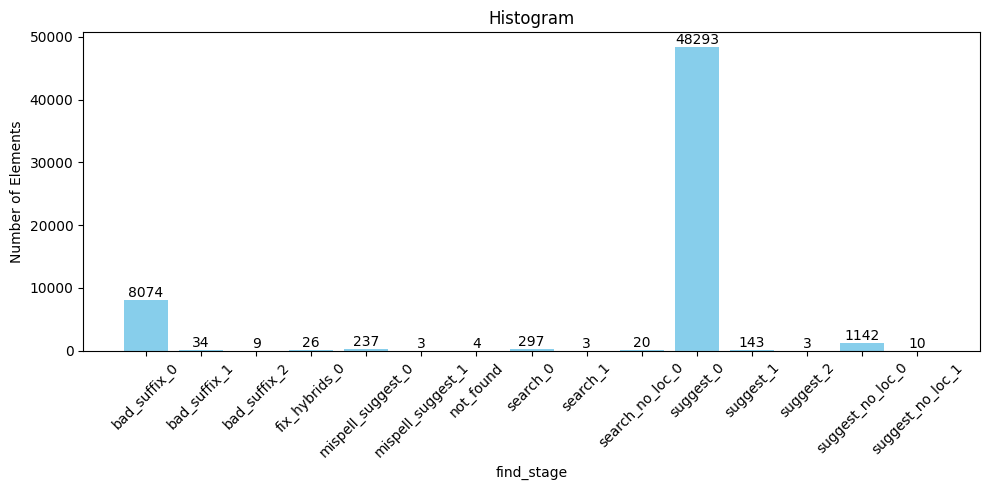

In [112]:
create_histogram(results,'find_stage', figsize=(10,5), sort_by='a')

In [59]:
count = 0
for result in results:
    last_char = result['find_stage'][-1]
    if last_char.isdigit():
        count += int(last_char)
print(count)

217


In [21]:
for result in results:
    found_name = str(result.get('found_from', ''))
    gbif_name = str(result.get('GBIF_canonical_name', ''))
    EPPO_names=result.get('EPPO_names', '')
    cleaned_name = clean(found_name, to_remove)
    if result['find_stage']=='mispell_suggest_1':
        print(f'{str(EPPO_names):<70} {result["index"]:<5} | {gbif_name:<30} | {compare_strings(cleaned_name, gbif_name):<3} | {result["find_stage"]:<10} | {result["rank_status"]}')

['Phoradendron juniperum subsp. libocedri', 'Phoradendron']            11060 | Phoradendron juniperinum       | 11  | mispell_suggest_1 | SPECIES_ACCEPTED
['Lilium leucanthemum var. centifolium', 'Lilium']                     13483 | Lilium leucanthum              | 14  | mispell_suggest_1 | SPECIES_ACCEPTED
['Catascopium nigritum', 'Catascopium']                                50848 | Catascopinus                   | 9   | mispell_suggest_1 | GENUS_SYNONYM
['Fibigia clypeolata subsp. eriocarpa', 'Fibigia']                     55424 | Fibigia clypeata               | 12  | mispell_suggest_1 | SPECIES_ACCEPTED


In [56]:
await EPPO_single('Brassica oleracea')

{'GBIF_canonical_name': 'Brassica oleracea',
 'rank_status': 'SPECIES_ACCEPTED',
 'rank': 'SPECIES',
 'status': 'ACCEPTED',
 'unique_id': 3042845,
 'result': {'key': 3042845,
  'nameKey': 1639641,
  'datasetKey': 'd7dddbf4-2cf0-4f39-9b2a-bb099caae36c',
  'constituentKey': '7ddf754f-d193-4cc9-b351-99906754a03b',
  'nubKey': 3042845,
  'parentKey': 3042506,
  'parent': 'Brassica',
  'kingdom': 'Plantae',
  'phylum': 'Tracheophyta',
  'order': 'Brassicales',
  'family': 'Brassicaceae',
  'genus': 'Brassica',
  'species': 'Brassica oleracea',
  'kingdomKey': 6,
  'phylumKey': 7707728,
  'classKey': 220,
  'orderKey': 7225535,
  'familyKey': 3112,
  'genusKey': 3042506,
  'speciesKey': 3042845,
  'scientificName': 'Brassica oleracea L.',
  'canonicalName': 'Brassica oleracea',
  'authorship': 'L.',
  'publishedIn': 'Linnaeus, C. von. Sp. Pl. 2: 667. (1753).',
  'nameType': 'SCIENTIFIC',
  'taxonomicStatus': 'ACCEPTED',
  'rank': 'SPECIES',
  'origin': 'SOURCE',
  'numDescendants': 10,
  'nu

# Results by kingdom

In [192]:
df_EPPO = pd.read_parquet('/workdir/EPPO Dataframes/Kingdom/df.Animalia.EPPO.gzip',engine='fastparquet')
df_EPPO.head(n=2)

,EPPO Code,Preferred name,Common names,Other scientific names,Associated Non-Taxonomic,Notes,Hosts,Vectors,Vectorof,Pests,Images,Keys,Distribution,Pathwayshosts,Datasheet,Taxolink,Taxonomy Info,Authority
index,,,,,,,,,,,,,,,,,,
7914,DACUDO,Bactrocera dorsalis,"[{'oriental fruit fly': 'English'}, {'oriental...","[Bactrocera invadens, Bactrocera papayae, Bact...",{},"B. invadens, B. papayae and B. philippinensis ...","{'BPHTH': 'Wild/Weed', 'DCYED': 'Wild/Weed', '...",None,None,None,"[{'tag': ['tag-larva'], 'url': 'https://gd.epp...","[, distribution, hosts, pathwayshosts, categor...","{'Present, no details': ['Africa/Angola/', 'Af...","{'1CIDG': ['plants for planting', 'fruits or v...",https://gd.eppo.int/taxon/DACUDO/datasheet,/1ANIMK/1ARTHP/1HEXAQ/1INSEC/1DIPTO/1TEPHF/1BC...,"{'Kingdom': 'Animalia', 'Phylum': 'Arthropoda'...",(Hendel)
10765,EUWAWH,Euwallacea fornicatus sensu stricto,[{'polyphagous shot-hole borer': 'English'}],"[Euwallacea whitfordiodendrus, Xyleborus forni...",{},Part of the complex Euwallacea fornicatus sens...,"{'ACAAF': 'Host', 'ACAFO': 'Host', 'ACALO': 'H...",None,{'FUSAEW': 'Known vector'},None,None,"[, distribution, hosts, vectorof, bca, categor...","{'Present, no details': ['Africa/South Africa/...",None,https://gd.eppo.int/taxon/EUWAWH/datasheet,/1ANIMK/1ARTHP/1HEXAQ/1INSEC/1COLEO/1CURCF/1SC...,"{'Kingdom': 'Animalia', 'Phylum': 'Arthropoda'...",(Eichhoff)


In [24]:
print(len(df_EPPO))
folder_path = '/workdir/EPPO Dataframes/Kingdom/'
for file_path in os.listdir(folder_path):
    print(folder_path+file_path)
    print(len(pd.read_parquet(folder_path+file_path, engine='fastparquet')))

27501
/workdir/EPPO Dataframes/Kingdom/df.Viruses and viroids.EPPO.gzip
1909
/workdir/EPPO Dataframes/Kingdom/df.Fungi.EPPO.gzip
8327
/workdir/EPPO Dataframes/Kingdom/df.Bacteria.EPPO.gzip
1029
/workdir/EPPO Dataframes/Kingdom/df.Chromista.EPPO.gzip
592
/workdir/EPPO Dataframes/Kingdom/df.Protista.EPPO.gzip
89
/workdir/EPPO Dataframes/Kingdom/df.Archaea.EPPO.gzip
13
/workdir/EPPO Dataframes/Kingdom/df.Plants.EPPO.gzip
58298
/workdir/EPPO Dataframes/Kingdom/df.Animalia.EPPO.gzip
27501


In [193]:
kingdoms = [
 'Archaea',
 'Bacteria',
 'Chromista',
 'Viruses_and_viroids',
 'Fungi',
 'Protista',
 'Plants',
 'Animalia']

In [195]:
kingdom_results={}
for kingdom in kingdoms:
    results = EPPO_to_GBIF_parallel(eppo_path=f'/workdir/EPPO Dataframes/Kingdom/df.{kingdom}.EPPO.gzip', num=-10, kingdom=kingdom)
    kingdom_results[kingdom] = results
    num_lost, num_not_found = metrix(results)
    print(f'Kingdom: {kingdom}, lost: {num_lost}, not_found: {num_not_found}')

Kingdom: Archaea, lost: 0, not_found: 0
Kingdom: Bacteria, lost: 204, not_found: 10
Kingdom: Chromista, lost: 28, not_found: 0
Kingdom: Viruses_and_viroids, lost: 21, not_found: 169
Kingdom: Fungi, lost: 166, not_found: 3
Kingdom: Protista, lost: 1, not_found: 2
Kingdom: Plants, lost: 205, not_found: 3
ERROR: input name: Saperda concolor, name for search: Saperda concolor, key: 8206867
Kingdom: Animalia, lost: 1881, not_found: 24


## Save dataframes and jsons for EPPO to GBIF

In [ ]:
def save_df(kingdom_json, filename):
    # convert the json content into dataframe and saves it
    
    all_columns = set()

    for EPPO_code, result in kingdom_json.items():
        if isinstance(result, dict):
            all_columns.update(result.keys())

    rows = []
        
    for EPPO_code, result in kingdom_json.items():
        if isinstance(result, dict):
            row = {col: None for col in all_columns}
            row.update({'EPPO_code': EPPO_code, 'found': True, **result})
            rows.append(row)
        else:
            row = {col: None for col in all_columns}
            row.update({'EPPO_code': EPPO_code, 'found': False})
            rows.append(row)
            
    columns = ['EPPO_code'] + list(all_columns) + ['found']
    kingdom_df = pd.DataFrame(rows, columns=columns)


    for col in kingdom_df.columns:
        # Check if the column contains integers and cast them appropriately
        if kingdom_df[col].apply(lambda x: isinstance(x, (float))).all():
            kingdom_df[col] = pd.to_numeric(kingdom_df[col].astype(pd.Int64Dtype()))
            
    kingdom_df.to_parquet(filename, index=False, compression="gzip", engine="fastparquet")  

In [234]:
for kingdom in kingdom_results:
    kingdom_json = {
        element['EPPO_code']: element.get('result', 'not_found')
        for element in kingdom_results[kingdom]
    }
    
    # Define the file name
    folder_path = '/workdir/EPPO_to_GBIF/'
    json_filename = f"{kingdom}_EPPO_to_GBIF.json"
    df_filename = f"df.{kingdom}_EPPO_to_GBIF.gzip"
    
    # Save the dataframe
    save_df(kingdom_json, folder_path+df_filename)
    print(f"Saved {df_filename}")
    
    # Save the JSON data to the file
    with open(folder_path+json_filename, 'w', encoding='utf-8') as f:
        json.dump(kingdom_json, f, indent=4, ensure_ascii=False)

    print(f"Saved {json_filename}")

Saved df.Archaea_EPPO_to_GBIF.gzip
Saved Archaea_EPPO_to_GBIF.json
Saved df.Bacteria_EPPO_to_GBIF.gzip
Saved Bacteria_EPPO_to_GBIF.json
Saved df.Chromista_EPPO_to_GBIF.gzip
Saved Chromista_EPPO_to_GBIF.json
Saved df.Viruses_and_viroids_EPPO_to_GBIF.gzip
Saved Viruses_and_viroids_EPPO_to_GBIF.json
Saved df.Fungi_EPPO_to_GBIF.gzip
Saved Fungi_EPPO_to_GBIF.json
Saved df.Protista_EPPO_to_GBIF.gzip
Saved Protista_EPPO_to_GBIF.json
Saved df.Plants_EPPO_to_GBIF.gzip
Saved Plants_EPPO_to_GBIF.json
Saved df.Animalia_EPPO_to_GBIF.gzip
Saved Animalia_EPPO_to_GBIF.json


In [62]:
kingdom='Animalia'
results = EPPO_to_GBIF_parallel(eppo_path=f'/workdir/EPPO Dataframes/Kingdom/df.{kingdom}.EPPO.gzip', num=-10, kingdom=kingdom)
num_lost, num_not_found = metrix(results)
print(f'Kingdom: {kingdom}, lost: {num_lost}, not_found: {num_not_found}')

KeyboardInterrupt: 

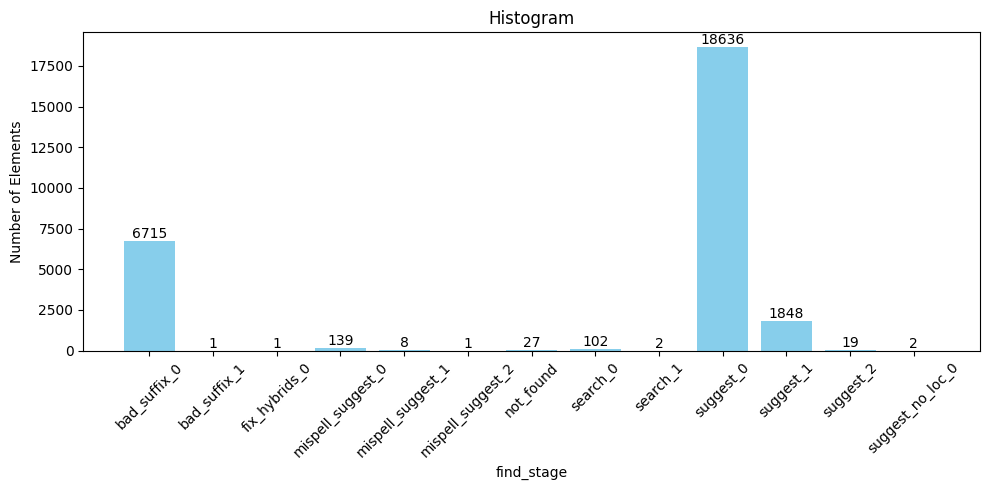

In [189]:
create_histogram(results,'find_stage', figsize=(10,5), sort_by='a')

In [191]:
c = 0
for result in results:
    found_name = str(result.get('found_from', ''))
    gbif_name = str(result.get('GBIF_canonical_name', ''))
    EPPO_names=result.get('EPPO_names', '')
    cleaned_name = clean(found_name, to_remove)
    if result['find_stage']=='mispell_suggest_0':# and compare_strings(cleaned_name, gbif_name) >= 1:
        c += 1
        print(f'{c}\t{str(found_name):<40} {result["index"]:<5} | {gbif_name:<30} | {compare_strings(cleaned_name, gbif_name):<3} | {result["find_stage"]:<10} | {result["rank_status"]}')

1	Resseliella citrifrugis                  469   | Resseliella citrifugis         | 1   | mispell_suggest_0 | SPECIES_ACCEPTED
2	Premnotrypes suturicallus                699   | Premnotrypes suturzcallus      | 1   | mispell_suggest_0 | SPECIES_ACCEPTED
3	Orgyia antiqua novae                     1113  | Orgyia antiqua nova            | 1   | mispell_suggest_0 | SUBSPECIES_ACCEPTED
4	Oxycarenus lectularius                   1243  | Oxycarenus lectularis          | 1   | mispell_suggest_0 | SPECIES_SYNONYM
5	Ornithodoros tartarovskyi                1333  | Ornithodoros tartakovskyi      | 1   | mispell_suggest_0 | SPECIES_ACCEPTED
6	Orthaga euandrusalis                     1341  | Orthaga euadrusalis            | 1   | mispell_suggest_0 | SPECIES_ACCEPTED
7	Notoxus monocerus                        1508  | Notoxus monoceros              | 1   | mispell_suggest_0 | SPECIES_ACCEPTED
8	Oncocephala angulaia                     1933  | Oncocephala angulata           | 1   | mispell_suggest_0 |

In [184]:
c = 0
for result in results:
    found_name = str(result.get('found_from', ''))
    gbif_name = str(result.get('GBIF_canonical_name', ''))
    EPPO_names=result.get('EPPO_names', '')
    cleaned_name = clean(found_name, to_remove)
    if result['find_stage']=='not_found' and EPPO_names[-1]:
        c+=1
        print(f'{c}\t{str(EPPO_names)}')

1	['Paralauca sp.', 'Paralauca']
2	['Paralauca dives', 'Paralauca']
3	['Ornithorhychus sp.', 'Ornithorhychus']
4	['Ornithorhychus anatinus', 'Ornithorhychus']
5	['Nitidinea sp.', 'Nitidinea']
6	['Opsopoedus emiliae', 'Opsopoedus']
7	['Ochromolopsis sp.', 'Ochromolopsis']
8	['Ochromolopsis ictella', 'Ochromolopsis']
9	['Pineodes sp.', 'Pineodes']
10	['Togarietettix sp.', 'Togarietettix']
11	['Pomphopoaea sp.', 'Pomphopoaea']
12	['Spanolepis selloanae', 'Spanolepis']
13	['Spanolepis sp.', 'Spanolepis']
14	['Rhinocloa sp.', 'Rhinocloa']
15	['Rachisphora sp.', 'Rachisphora']
16	['Byakushincecis sp.', 'Byakushincecis']
17	['Calytis sp.', 'Calytis']
18	['Bagnaliella yuccae', 'Bagnaliella']
19	['Compariella bifasciata', 'Compariella']
20	['Amerrhinus ynca', 'Amerrhinus']
21	['Amerrhinus sp.', 'Amerrhinus']
22	['Amerrhinus pantherinus', 'Amerrhinus']
23	['Ampullarium sp.', 'Ampullarium']
24	['Ampullarium canaliculatus', 'Ampullarium']
25	['Aetorhinus sp.', 'Aetorhinus']
26	['Apterygidia sp.', 

In [151]:
await EPPO_single('Apodemia', kingdom='Animalia')

method: suggest                        | scientific: Apodemia                       | search: ['Apodemia']                              | result: not found                     
method: search                         | scientific: Apodemia                       | search: ['Apodemia']                              | result: not found                     
method: suggest_no_loc                 | scientific: Apodemia                       | search: ['Apodemia']                              | result: not found                     
method: search_no_loc                  | scientific: Apodemia                       | search: ['Apodemia']                              | result: not found                     
method: mispell_suggest                | scientific: Apodemia                       | search: ['Apodemi', 'Apodem', 'Apode', 'Apod', 'Apo', 'Ap', 'A']  | result: Apodesmia                     


{'GBIF_canonical_name': 'Apodesmia',
 'rank_status': 'GENUS_ACCEPTED',
 'unique_id': 9090242,
 'find_stage': 'mispell_suggest'}

In [200]:
c=0
for result in results:
    if 'DOUBTFUL' in result['rank_status']:
        c += 1
        print(c, '\t', result)

1 	 {'GBIF_canonical_name': 'Characoma stictigrapta', 'rank_status': 'SPECIES_DOUBTFUL', 'unique_id': 1801353, 'find_stage': 'suggest_0', 'found_from': 'Characoma stictigrapta', 'EPPO_names': ['Characoma stictigrapta', 'Characoma'], 'index': 768}
2 	 {'GBIF_canonical_name': 'Ovatus crataegarius', 'rank_status': 'SPECIES_DOUBTFUL', 'unique_id': 2074869, 'find_stage': 'suggest_0', 'found_from': 'Ovatus crataegarius', 'EPPO_names': ['Ovatus crataegarius', 'Aphis melissae', 'Ovatus melissae', 'Ovatus'], 'index': 1129}
3 	 {'GBIF_canonical_name': 'Nuculaspis', 'rank_status': 'GENUS_DOUBTFUL', 'unique_id': 2084983, 'find_stage': 'bad_suffix_0', 'found_from': 'Nuculaspis sp.', 'EPPO_names': ['Nuculaspis sp.', 'Nuculaspis'], 'index': 1458}
4 	 {'GBIF_canonical_name': 'Nuculaspis', 'rank_status': 'GENUS_DOUBTFUL', 'unique_id': 2084983, 'find_stage': 'suggest_1', 'found_from': 'Nuculaspis californica', 'EPPO_names': ['Nuculaspis californica', 'Nuculaspis'], 'index': 1459}
5 	 {'GBIF_canonical_na

In [164]:
for _, row in df_EPPO.iterrows():
    if row['Taxonomy Info'].get('Genus')=='Apodemia':
        print(row['Taxonomy Info'])

{'Kingdom': 'Animalia', 'Phylum': 'Arthropoda', 'Subphylum': 'Hexapoda', 'Class': 'Insecta', 'Order': 'Lepidoptera', 'Family': 'Lycaenidae', 'Genus': 'Apodemia', 'Species': 'Apodemia sp.'}
{'Kingdom': 'Animalia', 'Phylum': 'Arthropoda', 'Subphylum': 'Hexapoda', 'Class': 'Insecta', 'Order': 'Lepidoptera', 'Family': 'Lycaenidae', 'Genus': 'Apodemia', 'Species': 'Apodemia mormo langei'}


## Split Microorganisms dataframes

In [17]:
eppo_path='/workdir/EPPO Dataframes/df.micro.scraped.sorted.gzip'
df_EPPO = pd.read_parquet(eppo_path, engine='fastparquet')

In [259]:
kingdom_dfs = {}

# Loop through rows to sort data by Kingdom
for _, row in df_EPPO.iterrows():
    kingdom = row.get('Taxonomy Info').get('Kingdom')
    if kingdom not in kingdom_dfs:
        kingdom_dfs[kingdom] = pd.DataFrame(columns=df_EPPO.columns)  # Create new DataFrame for each kingdom
    kingdom_dfs[kingdom] = pd.concat([kingdom_dfs[kingdom], pd.DataFrame([row])], ignore_index=True)

# Save each DataFrame to a gzip file
for kingdom, kingdom_df in kingdom_dfs.items():
    filename = f"/workdir/EPPO Dataframes/Kingdom/df.{kingdom}.EPPO.gzip"
    kingdom_df.to_parquet(filename, index=False, compression="gzip")
    print(f"Saved {filename}")

Saved /workdir/EPPO Dataframes/Kingdom/df.Viruses and viroids.EPPO.gzip
Saved /workdir/EPPO Dataframes/Kingdom/df.Fungi.EPPO.gzip
Saved /workdir/EPPO Dataframes/Kingdom/df.Bacteria.EPPO.gzip
Saved /workdir/EPPO Dataframes/Kingdom/df.Chromista.EPPO.gzip
Saved /workdir/EPPO Dataframes/Kingdom/df.Protista.EPPO.gzip
Saved /workdir/EPPO Dataframes/Kingdom/df.Archaea.EPPO.gzip
Saved /workdir/EPPO Dataframes/Kingdom/df.None.EPPO.gzip


# Examples

In [60]:
for result in results:
    found_name = str(result.get('found_from', ''))
    gbif_name = str(result.get('GBIF_canonical_name', ''))
    EPPO_names=result.get('EPPO_names', '')
    cleaned_name = clean(found_name, to_remove)
    if result['find_stage']=='fix_hybrids_0':
        print(f'{str(found_name):<70} {result["index"]:<5} | {gbif_name:<30} | {compare_strings(cleaned_name, gbif_name):<3} | {result["find_stage"]:<10} | {result["rank_status"]}')

Eucalyptus urophylla x Eucalyptus grandis                              1092  | Eucalyptus                     | 29  | fix_hybrids_0 | GENUS_ACCEPTED
Rubus fructicosus x Rubus idaeus                                       1297  | Rubus                          | 25  | fix_hybrids_0 | GENUS_ACCEPTED
Citrus paradisi x Poncirus trifoliata                                  1352  | Citrus                         | 29  | fix_hybrids_0 | GENUS_ACCEPTED
Lavandula lanata x Lavandula angustifolia subsp. angustifolia          6431  | Lavandula                      | 43  | fix_hybrids_0 | GENUS_ACCEPTED
Paulownia fortunei x Paulownia tomentosa                               8669  | Paulownia                      | 29  | fix_hybrids_0 | GENUS_ACCEPTED
Prunus cerasifera x Prunus persica                                     10254 | Prunus                         | 26  | fix_hybrids_0 | GENUS_ACCEPTED
Philodendron erubescens x P. hastatum                                  10699 | Philodendron               

In [26]:
def print_problems(stage, include_genus=False, all_names=False,level=0):
    c=0
    for result in results:
        found_name = str(result.get('found_from', ''))
        gbif_name = str(result.get('GBIF_canonical_name', ''))
        EPPO_names=result.get('EPPO_names', '')
        cleaned_name = clean(found_name, to_remove)
        name_to_print = (EPPO_names if all_names else found_name)
        if (include_genus and result["rank_status"].startswith("GENUS")) or \
            (not include_genus and not result["rank_status"].startswith("GENUS")): 
            if result["find_stage"][-1]==str(level) and 'bad_suffix' not in result["find_stage"]:
                c=c+1
                print(f'{c:<3} | {str(found_name):<52} ({result["index"]}) | {gbif_name:<30} | {compare_strings(cleaned_name, gbif_name):<3} | {result["find_stage"]:<10} | {result["rank_status"]}')

In [49]:
def print_stage(stage, include_genus=False, all_names=False):
    c=0
    bad_suffix = ['sp.', 'hybrids', 'hybridus', '(s.l.)', 'sp,']
    for result in results:
        found_name = str(result.get('found_from', ''))
        gbif_name = str(result.get('GBIF_canonical_name', ''))
        EPPO_names=result.get('EPPO_names', '')
        cleaned_name = clean(found_name, to_remove)
        # Problems: Rosa Hybrid , _ x _
        name_to_print = (EPPO_names if all_names else found_name)
        if result["find_stage"]==stage:
            if include_genus:
                if result["rank_status"].startswith('GENUS'):
                    c=c+1
                    print(f'{c:<3} | {str(name_to_print):<52} ({result["index"]}) | {gbif_name:<30} | {compare_strings(cleaned_name, gbif_name):<3} | {result["find_stage"]:<10} | {result["rank_status"]}')
            elif not result["rank_status"].startswith('GENUS'):
                c=c+1
                print(f'{c:<3} | {str(name_to_print):<52} ({result["index"]}) | {gbif_name:<30} | {compare_strings(cleaned_name, gbif_name):<3} | {result["find_stage"]:<10} | {result["rank_status"]}')

In [50]:
c=0
bad_suffix = ['sp.', 'hybrids', 'hybridus', '(s.l.)', 'sp,']
for result in results:
    found_name = str(result.get('found_from', ''))
    gbif_name = str(result.get('GBIF_canonical_name', ''))
    EPPO_names=result.get('EPPO_names', '')
    cleaned_name = clean(found_name, to_remove)
    # print(f'{c:<3} | {found_name:<67} | {gbif_name:<50} | {result["rank_status"]}')
    if result["find_stage"] not in ['suggest_genus','search_genus']:
        if ' x ' in found_name and len(found_name.split()) > 3:
            c=c+1
            print(f'{c:<3} | {str(found_name):<67} ({result["index"]}) | {gbif_name:<50} | {compare_strings(cleaned_name, gbif_name):<3} | {result["find_stage"]:<30} | {result["rank_status"]}')

1   | Eucalyptus urophylla x Eucalyptus grandis                           (1092) | Eucalyptus                                         | 29  | fix_hybrids_0                  | GENUS_ACCEPTED
2   | Rubus fructicosus x Rubus idaeus                                    (1297) | Rubus                                              | 25  | fix_hybrids_0                  | GENUS_ACCEPTED
3   | Citrus paradisi x Poncirus trifoliata                               (1352) | Citrus                                             | 29  | fix_hybrids_0                  | GENUS_ACCEPTED
4   | Lavandula lanata x Lavandula angustifolia subsp. angustifolia       (6431) | Lavandula                                          | 43  | fix_hybrids_0                  | GENUS_ACCEPTED
5   | Paulownia fortunei x Paulownia tomentosa                            (8669) | Paulownia                                          | 29  | fix_hybrids_0                  | GENUS_ACCEPTED
6   | Prunus cerasifera x Prunus persica          

In [334]:
c=0

for result in results:
    found_name = str(result.get('found_from', ''))
    gbif_name = str(result.get('GBIF_canonical_name', ''))
    words=found_name.split()
    if len(words)==2 and not words[1] in ['sp.','hybrids']:
        if 2 > compare_strings(found_name, gbif_name) > 0:
            c+=1
            # print(f'{c:<3} | {found_name:<67} | {gbif_name:<50} | {result["rank_status"]}')
            print(f'{c:<3} | {found_name:<67} | {gbif_name:<50} | {compare_strings(found_name, gbif_name):<3} | {result["find_stage"]:<30} | {result["rank_status"]}')

1   | Prunus jamazakura                                                   | Prunus jamasakura                                  | 1   | mispell_suggest                | SPECIES_ACCEPTED
2   | Larix principis-ruprechtii                                          | Larix principis-rupprechtii                        | 1   | search                         | SPECIES_SYNONYM
3   | Quercus wislizenii                                                  | Quercus wislizeni                                  | 1   | search                         | SPECIES_ACCEPTED
4   | Sechium tacao                                                       | Sechium tacaco                                     | 1   | mispell_suggest                | SPECIES_SYNONYM
5   | Quercus fabri                                                       | Quercus fabrei                                     | 1   | search                         | SPECIES_ACCEPTED
6   | Eucalyptus nova-anglia                                              | E

In [62]:
to_remove = [' x ', ' × ', ' var. ', ' subsp. ' , ' f. ']
bad_suffix = [' sp.', ' hybrids', ' hybridus', ' (s.l.)', ' sp,']
to_remove=to_remove+bad_suffix
def clean(string, to_remove):
    for substring in to_remove:
        string = string.replace(substring, ' ')
    if string.startswith('x ') or string.startswith('+ ') or string.startswith('× ') or string.startswith('+ '): 
        string = string[2:]
    return string

c=0
for result in results:
    found_name = str(result.get('found_from', ''))
    gbif_name = str(result.get('GBIF_canonical_name', ''))
    if not result.get('rank_status',' ').startswith('GENUS'):
        if len(found_name.split())==2 and len(gbif_name.split())!=2:
            comparation = compare_strings(clean(found_name,to_remove+bad_suffix), gbif_name)
            if comparation < 0.95:
                c+=1
                # print(f'{c:<3} | {found_name:<67} | {gbif_name:<50} | {result["rank_status"]}')
                print(f'{c:<3} | {found_name:<67} | {gbif_name:<50} | {str(comparation)[:5]:<3} |{result["find_stage"]:<30} | {result["rank_status"]}')

1   | Taraxacum longeappendiculatum                                       | Taraxacum longeappendiculatum nakaii               | 0.892 |suggest                        | VARIETY_SYNONYM
2   | Sisyrinchium bermudianum                                            | Sisyrinchium bermudianum minus                     | 0.888 |suggest                        | VARIETY_SYNONYM


In [220]:
c=0
for result in results:
    found_name = str(result.get('found_from', ''))
    gbif_name = str(result.get('GBIF_canonical_name', ''))
    if not result.get('rank_status',' ').startswith('GENUS') and found_name and result["find_stage"]=='search_first_last_names':
        if compare_strings(clean(found_name,to_remove+bad_suffix), gbif_name) < 0.9:
            c+=1
            # print(f'{c:<3} | {found_name:<67} | {gbif_name:<50} | {result["rank_status"]}')
            print(f'{c:<3} | {found_name:<67} | {gbif_name:<50} | {result["find_stage"]:<30} | {result["rank_status"]}')

In [156]:
for result in results:
    if result['find_stage'] == 'not_found':
        print(result['EPPO_names'], result['index'])

['Naufragia sp.'] 17680
['Xolocoltzia sp.'] 22535
['Traunsteineria sp.'] 23288
['Plectostachys serpyllifolia'] 26471
['Plectostachys sp.'] 26472
['Phenacospermum sp.'] 27475
['Gossypeanthus sp.'] 46511
['Chaerospondias sp.'] 48176
['Catascopium nigritum'] 50848
['Catascopium sp.'] 50849
['Dregia sp.'] 53611


In [134]:
for result in results:
    if result['find_stage'] == 'not_found':
        print(result.get('EPPO_names'), '|', result.get('GBIF_canonical_name', 'Diobestion!'))

['Luvunda sp.'] | None
['Lethanthopsis sp.'] | None
['Molopospemum sp.'] | None
['Naufragia sp.'] | None
['Tetrasastris sp.'] | None
['Warszewicia sp.'] | None
['Xolocoltzia sp.'] | None
['Traunsteineria sp.'] | None
['Plectostachys sp.'] | None
['Phenacospermum sp.'] | None
['Pentapragma begoniifolia'] | None
['Achys sp.'] | None
['Gossypeanthus sp.'] | None
['Chaerospondias sp.'] | None
['Cyphoderma sp.'] | None
['Crypolepis grandiflora'] | None
['Catascopium sp.'] | None
['Dregia sp.'] | None
['Elaeaosticta sp.'] | None


In [131]:
for result in results:
    if result['find_stage'] == 'mispell_suggest':
        print(result['found_from'], '|', result['GBIF_canonical_name'])

Mussaena arcuata | Mussaenda divaricata
Mesembyanthemum theurkauffii | Mesembryanthemum excavatum
Malabaia aurea | Malabaila graveolens
Metzeria conjugata | Metzgeria lechleri
Neolitsia caffea | Neolitsea vuquangensis
Tarconanthus trilobus | Limonium tarcoense
Vochsia spathulata | Vochysia santaluciae
Vespa multinervatus | Alpinia nidus-vespae
Plectostachys serpyllifolia | Cynodon plectostachyus
Pleiocnemia leuzeana | Pleioceras barteri
Sarkosperma ovatifolium | Ceropegia sarkariae
Stemonorus apicalis | Stemonoporus gilimalensis
Amaiaoua intermedia | Alsophila amaiambitensis
Burcharia congesta | Zygophyllum burcharicum
Grewa hexamita | Grewia humblotii
Guiaroa arvensis | Maxillaria guiardiana
Helanthus anomalus | Helanthium zombiense
Helianthermum ellipticum | Helianthermum oelandicum canescens
Iguanua wallichiana | Iguanura tenuis
Catascopium nigritum | Taraxacum cataschistum
Encalyptra brevicolla | Encalyptra vulgaris


In [49]:
for result in results:
    if result['GBIF_canonical_name'] and result['find_stage'] == 'suggest_genus' and result['GBIF_canonical_name'].startswith('X'):
        print(result)

{'GBIF_canonical_name': 'Xanthosoma', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 2872044, 'find_stage': 'suggest_genus', 'found_from': 'Xanthosoma sp.', 'EPPO_names': ['Xanthosoma sp.'], 'index': 2080}
{'GBIF_canonical_name': 'Xanthium', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 3089139, 'find_stage': 'suggest_genus', 'found_from': 'Xanthium sp.', 'EPPO_names': ['Xanthium sp.'], 'index': 5234}
{'GBIF_canonical_name': 'Xylosma', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 2874117, 'find_stage': 'suggest_genus', 'found_from': 'Xylosma sp.', 'EPPO_names': ['Xylosma sp.'], 'index': 6620}
{'GBIF_canonical_name': 'Xanthophyllum', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 7293349, 'find_stage': 'suggest_genus', 'found_from': 'Xanthophyllum sp.', 'EPPO_names': ['Xanthophyllum sp.'], 'index': 21330}
{'GBIF_canonical_name': 'Xanthorhiza', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 3033661, 'find_stage': 'suggest_genus', 'found_from': 'Xanthorhiza sp.', 'EPPO_names': ['Xanthorhiza

In [59]:
for result in results:
    if result.get('found_from','').startswith('Achi'):
        print(result)

{'GBIF_canonical_name': 'Achillea millefolium', 'rank_status': 'SPECIES_ACCEPTED', 'unique_id': 3120060, 'find_stage': 'suggest', 'found_from': 'Achillea millefolium', 'EPPO_names': ['Achillea millefolium', 'Achillea millefolium subsp. millefolium', 'Achillea submillefolium'], 'index': 2840}
{'GBIF_canonical_name': 'Achillea', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 3119995, 'find_stage': 'suggest_genus', 'found_from': 'Achillea sp.', 'EPPO_names': ['Achillea sp.'], 'index': 6298}
{'GBIF_canonical_name': 'Achillea ptarmica', 'rank_status': 'SPECIES_ACCEPTED', 'unique_id': 3120333, 'find_stage': 'suggest', 'found_from': 'Achillea ptarmica', 'EPPO_names': ['Achillea ptarmica', 'Ptarmica vulgaris'], 'index': 6340}
{'GBIF_canonical_name': 'Achimenes', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 3233488, 'find_stage': 'suggest_genus', 'found_from': 'Achimenes sp.', 'EPPO_names': ['Achimenes sp.'], 'index': 7589}
{'GBIF_canonical_name': 'Achillea maritima', 'rank_status': 'SPECIES_AC

In [79]:
for result in results:
    if result['find_stage'] == 'not_found':
        for elem in results:
            if elem['find_stage'] == 'suggest_genus':
                if compare_string(result.get('EPPO_names',['x'])[0].split()[0],(elem.get('GBIF_canonical_name','y') if elem.get('GBIF_canonical_name','y') else 'y'))>0.88: #
                    print(result,elem)

{'GBIF_canonical_name': None, 'rank_status': 'NOT_FOUND', 'unique_id': None, 'find_stage': 'not_found', 'EPPO_names': ['Mussaena arcuata'], 'index': 11221} {'GBIF_canonical_name': 'Mussaenda', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 2892394, 'find_stage': 'suggest_genus', 'found_from': 'Mussaenda sp.', 'EPPO_names': ['Mussaenda sp.'], 'index': 5028}
{'GBIF_canonical_name': None, 'rank_status': 'NOT_FOUND', 'unique_id': None, 'find_stage': 'not_found', 'EPPO_names': ['Mesembyanthemum theurkauffii'], 'index': 11432} {'GBIF_canonical_name': 'Mesembryanthemum', 'rank_status': 'GENUS_ACCEPTED', 'unique_id': 3084836, 'find_stage': 'suggest_genus', 'found_from': 'Mesembryanthemum sp.', 'EPPO_names': ['Mesembryanthemum sp.'], 'index': 11431}
{'GBIF_canonical_name': None, 'rank_status': 'NOT_FOUND', 'unique_id': None, 'find_stage': 'not_found', 'EPPO_names': ['Malabaia aurea'], 'index': 11892} {'GBIF_canonical_name': 'Malabaila', 'rank_status': 'GENUS_SYNONYM', 'unique_id': 5428456, 'find

In [54]:
c = 0
for result in results:
    
    if result['find_stage'] == 'search':
        c += 1
        print(f'{c:<3} | {result["index"]:<5} | {str(result["EPPO_names"]):<120} | {result["GBIF_canonical_name"]}')
        

1   | 798   | ['Larix gmelinii var. principis-ruprechtii', 'Larix principis-ruprechtii']                                               | Larix principis-rupprechtii
2   | 1032  | ['Quercus wislizenii']                                                                                                   | Quercus wislizeni
3   | 1159  | ['Quercus fabri']                                                                                                        | Quercus fabrei
4   | 2325  | ['Viburnum davidii']                                                                                                     | Viburnum davidi
5   | 5412  | ['Agave desmettiana']                                                                                                    | Agave desmetiana
6   | 5879  | ['Centrosema plumierii']                                                                                                 | Centrosema plumieri
7   | 7528  | ['Sehima nervosum', 'Isachne laxum']              

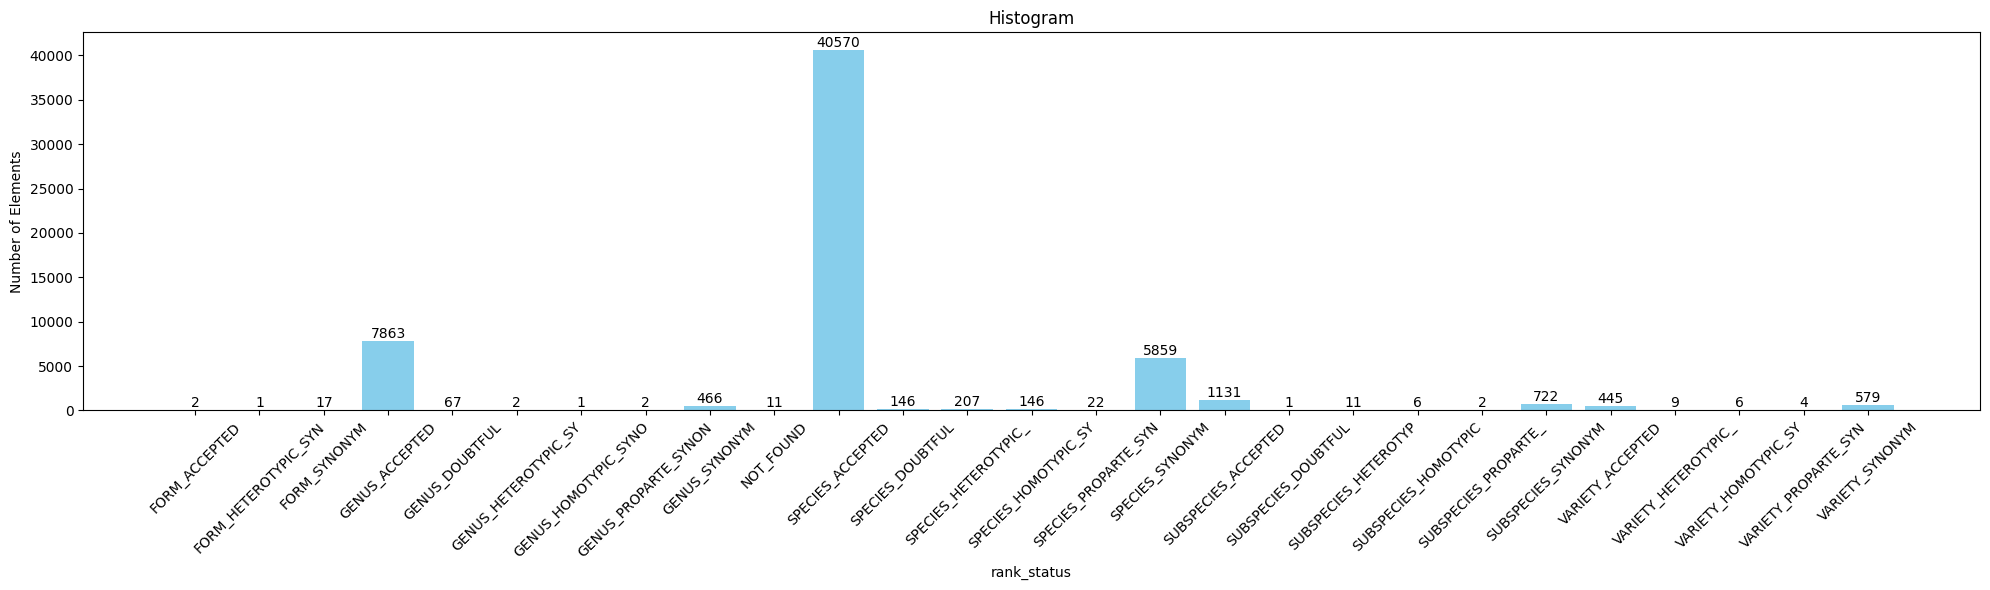

In [198]:
create_histogram(results,'rank_status',sort_by='a')

In [144]:
c=0
for i,element in enumerate(parallel):
    if element['find_stage']=='not_found':
        c=c+1
        print(f'{c:<3} | {element["index"]:<5} | {element["EPPO_name"]}')

1   | 1105  | Sechium tacao
2   | 1218  | Eucalyptus nova-anglia
3   | 1505  | Ribes sachalinensis
4   | 1903  | Lycium carolineanum
5   | 2421  | Passiflora sexiflora
6   | 2888  | Ipomoea crespidiformis
7   | 5352  | Senecio reinholdi
8   | 7814  | Panicum paniciformis
9   | 7837  | Pseudosasa taxifolia
10  | 7855  | Pogostemon brachystachys
11  | 7913  | Psychotria annulata
12  | 8301  | Pavetta eylesia
13  | 8391  | Phoebe ambiguum
14  | 8713  | Populus razumovskiana
15  | 8735  | Paspalum missionum
16  | 9259  | Pithecoctenium cynanchioides
17  | 9261  | Pithophora zelleri
18  | 9323  | Picea brachystyla
19  | 10003 | Platanthera hohnboei
20  | 10134 | Pernettya furens
21  | 10229 | Physostigma mesopotamicum
22  | 10423 | Psiadia punctata
23  | 10733 | Phoradendron capitallatum
24  | 10735 | Phoradendron juniperum subsp. juniperum
25  | 10885 | Physalis lancifolia
26  | 11079 | Phygelius x rectus
27  | 11086 | Philadelphus penduliformis
28  | 11221 | Mussaena arcuata
29  | 11284 |

In [145]:
# Per i good confronto tra nomi in input e canonical name ottenuti dalla call api
# PROBLEMA 1: ritorna delle varietà quando c'è una specie (not accepted) che potrebbe ritornare: Fatto
# esempi: 'Desmodium elegans', 'Ribes setosum', ... rank='SPECIES', status='HETEROTYPIC_SYNONYM'
# IDEA: in get_speciesID se c'è una response con rank SPECIES (e solo una) ritornare quella? rank SPECIES e chiave minima?
# status synonym maybe ok... SPECIES WITH EVERY STATUS???

#for elem in parallel:
#    if elem['find_stage']=='not_found':
#        print(elem['EPPO_name'],elem['GBIF_canonical_name'])

to_remove = [' x ', ' × ', ' var. ', ' subsp. ' , ' f. ']

def clean(string, to_remove):
    for substring in to_remove:
        string = string.replace(substring, ' ')
    if string.startswith('x ') or string.startswith('+ ') or string.startswith('× ') or string.startswith('+ '): 
        string = string[2:]
    return string
        
c=0
for element in parallel:
    problem=None
    cleaned_key = clean(element['EPPO_name'], to_remove)
    if element['GBIF_canonical_name']:
        if cleaned_key != element['GBIF_canonical_name']:
            if cleaned_key[:-1] == element['GBIF_canonical_name']:
                #print('L"ho beccato')
                problem='last letter'
            if cleaned_key == element['GBIF_canonical_name'][:-1]:
                #print('L"ho beccato2')
                problem='last letter 2'
            if cleaned_key.replace('i','y')==element['GBIF_canonical_name'].replace('i','y'):
                problem='i y inversion'
            if cleaned_key.replace('i','j')==element['GBIF_canonical_name'].replace('i','j'):
                problem='i j inversion'
            if cleaned_key.replace('-','')==element['GBIF_canonical_name'].replace('-',''):
                problem='trattino'
            #c+=1
            if not problem:
                c+=1
                print(f'{c:<3}| {element["index"]:<5} | {element["EPPO_name"]:<55} | {element["GBIF_canonical_name"]:<40} | {element["rank_status"]:<30}| {element["find_stage"]}')
                #|{problem:<15}

    #else:
    #    print(cleaned_key, elem['GBIF_canonical_name'])

1  | 19    | Citrus x aurantium var. unshiu                          | Citrus unshiu                            | SPECIES_PROPARTE_SYNONYM      | only_last_search
2  | 21    | Citrus x limonia var. jambhiri                          | Citrus jambhiri                          | SPECIES_PROPARTE_SYNONYM      | only_last_search
3  | 29    | Citrus x aurantium var. deliciosa                       | Citrus deliciosa                         | SPECIES_PROPARTE_SYNONYM      | only_last_search
4  | 32    | Citrus x limon var. limettioides                        | Citrus limettioides                      | SPECIES_SYNONYM               | only_last_search
5  | 33    | Citrus x aurantium var. clementina                      | Citrus clementina                        | SPECIES_SYNONYM               | only_last_search
6  | 35    | Citrus x aurantium var. tangerina                       | Citrus tangerina                         | SPECIES_PROPARTE_SYNONYM      | only_last_search
7  | 39    | Citrus x 

In [92]:
parallel = await EPPO_to_GBIF_random(len(EPPO_scie))

# Mufasa

In [ ]:
# #######################*#***********+++++++d++++++++++**********************************************
# ########################**********++++++++++++++++**************************************************
# ########################********+++++++++++++++*****************************************************
# ########################*******+++++++++++++********************************************************
# #######################******+++++++++++++**********************************************************
# #####################******++++++++++++++***********************************************************
# ####################******++++++++++++++++**********************************************************
# #################*******+++++++++++++++++++*********************************************************
# ###############*******+++++++++++++++++++++++********#######****************************************
# #############********++++++++++++++++++++++********%################********************************
# ########***********+++++++++++++++++++++++*******#################***#************************++++++
# ####**************+++++++++++++++++++++++******%%#%###############****#********************+++++++++
# *****************+++++++++++++++++++++*******%%%%################*********************++++++++++dddd
# **************+++++++++++++++++++*********+%%%%%######%%%%%%%%###******#************+++++++ddddddddd
# ************+++++++++++++++++++********+%%%%%%#####%%%%%%%%%%%%%%#*****#%%%%%%%**+++++++ddddddd-----
# *********++++++***++++++++++********%%%%%%%%%####%%###%%%%%%%%%%%%#****#%%####***#++++dddddd--------
# *******************+++++********#%%%%%%%%%%%####%##%%%%%%%%%%%%%%%%###*#%#######***++ddddd------dddd
# *****************++**********%%%%%%%%%%%%%%#######%%%%%%#*@@%+++*%%%##*#%#%%%%%%#***ddddddddddd+++++
# **************************#%%%%%%%%%%%%%%%#######%%%%#+*@####@%++dd+####%%%%%%%%%#*#+dddd+++++++++++
# *************************#%%%%%%%%%%%%%%########%%%#++********##dddddd+dd*%%%%%%%#*#*+++++++++++++++
# ***********************##%%%%%%%%%%%%%%%########%%*+++d****-+**#dddddddddddd+%%%%%*#++++++++++++++++
# **********************##%%%%%%%%***++%########%%%*++++++--%#%-*++dddddddddd@@%@%%%##++++************
# *********************##%%%%%%%%%#%%%%#######%@@#++*++++d++---++*+ddddddddd##**+%%##*+++*************
# **********************%%%%%%%%%##%######%%%@@*++++++++#+dddd++++ddddddddddd%d+*%%##*+++*************
# *****##**************%%%%%%%%%%%%####%%%%%%*+*#++++++++++*+d+++ddddddddddddd++d%%##**++*************
# #############*******%%%%%%%%%#%%#####%%%%%++++++++++#+++++d*---ddddddddddddddd+d%##**++*************
# ################***%%%%%%%%%%#%######%%%%+++++++++++++++#+d--+--d+#####ddddddddd+%##****************
# ##################%%%%%%%%%#%######%%%%%+++++++++++++++++d-------*########ddddddd+%##***************
# #################%%%%%%%%%%%######%%%%%+++#++++++++++++++dd-------*@@@#####**#**#######***********++
# ################%%%%%%%%%%%%#####%%%%%*+++++++++++++++++ddd--------+@@%#####%####d#%##**********+++d
# ###############%%%%%%%%%%##%######%%%%*++++++++++#*+++++d#dd---------%%#######@@-d#%##********+++ddd
# ##############%%%%%%%%%%##%######%%%%%++++++++*++*+*+++*-ddddd--------d######*d---#%#%*#*+*++++ddddd
# #############%%%%%%%%%%%#%%#####%%%%%%*++++++++******++dddddd------------%-------##%#%***+++ddddd---
# ############%%%%%%%%%%%%%%%#####%%%%%%%*++++++*********ddddddd----------#-------*###%%#**ddddd------
# ##******#*#%%%%%%%%%%%%%%%#%%##%%%%##%%#+++++**####***ddddd+*d---dddddd*#d-----*####%%#*#ddd--------
# *********#%%%%%%%%%%%%%%%%#%%#%%%%%##%%%+**#@%%%%%%@#++ddddd---------------%d-d#####%###*dddddd-----
# *******##%%%%%%%%%@%%%%%%%#%%##%%%%####%%%%%%%%%%%%%%#++ddddddd----------------#########+ddddddd----
# ******##%%%%%%%%%@@%%%%%#%%%%#%%%%######%%@%%%%%%%%%%@%++ddddddd---------------########*dddddddddddd
# *****###%%%%%%%%@@%%%%%%#%%%%#%%%%%#######%%%%%%%%%%%%%%%+ddddddd-------------d#######*+dddddddddddd
# +++###%%%%%%%%@@@@%%%%%%##%%%##%%%%%########%%@%%%%%%%%%%%*+ddddddd----------d%######**ddddddddddddd
# ++**%#%%%%%%%@%%@@%%%%%##%%%#%###%%%%%########%%%@@%%%%%%%%%*dd+dddd---------d#####*#*dddddddddddddd
# +**##%%%%%%@@%%@@%%%%%%##%%%%######%%%###########%%%@@%%%%@%%%%+%+dddd-------######**+dddddddddddddd
# *###%%%%%%%@@%%@@%%%%%%%##%%%%#######%##############%%%%%%%%%%%%%#%%+##%d--d#######**ddddddddddddddd
# ###%%%%%%%@@%%@@%%%%%%%%##%%%%%#########################%%@%%%%%%%%#################ddddddddddddddd+
# #%%%%%%%%@@@@%@@@@@%%%%%%%%%%%%%##%########################%%%%%%%%%###############+dddddddddddd++++
# #%%%%%%%%@@@@@@@@@@@%%%%%%%%%%%%%##%##########################%%%%%%#%############++++ddddddd+++++++
# %%%%%%%@%@@@@@@@@@@@%%%%%%%%%%%%%%%%%############################%##%#############+++++dddd+++++++++
# %%%%%@@@@@@@@@@@@@@@%%%%%%%%%%%%%%%%%%%############################%%##############+++++++++++++++++
# %%%%%@@@@@@@@@@@@@@%@@@@%%%%%%%%%%%%%%%%##############################%#############++++++++++++++++
# %%%%@@@@@@@@@@@@%%%#########%%%%%%%%%%%%%%##%#########################################++++++++++++++
# %%%@@@@@@@@@@%%%%####****+++**#%%%%%%%%%%%%#%%##################################*####*#*++++++++++++
# %%@@@@@@@@@@%%%#####***+++++++++*%%%%%%%%%%%#%%##################################*####****++++++++++
# %%@@@@@@@@@%%%#####***+++++++ddd++*%%%%%%%%%%%%##%###############################**####*****++++++++
# %@@@@@@@@%%%######**++++++++dddddd++%%%%%%%%%%%%%%##################################*********+++++++
# @@@@@@%%%%######***++++++++ddddddddd+#%%%%%%%%%%%%##################################*******+++++++++
# @@@@@@%%%######***++++++++++ddddddddd+*%%%%%%%%%%%%%@%%######################*######******++++++++++
# @@@@@%%%######***+++++++++++ddddddddddd*%%%%%%%%%%%%%%%%#############################******++++++++d
# @@@@%%%######***++++++++++++ddddddddddd+#%%%%%%%%%%%%%%%%%%#################*#########****++++dddddd
# @@@%%%######****+++++++++++ddddddddddddd+%%%%%%%%%%%%%%%%%%%%%#######################*****++ddd=====
# @%%%%######****+++++++++++++===========++*%%%%%%%%%%%%%%%%%%%########################**##=+======---
# %%%%#######***+++++++++++++++++==++=+==+++%%%%%%%%%%%%%%%%%%%#########################*##===========
# %%#%######***++++++++++++++++++=++=+++=+++#%%%%%%%%%%%%%%%%%%%#%######################*##*==========
# %%#######***+++++++++++++++++++++++++++=++#%%%%%%%%%%%%%%%%%%%%########################***==========
# %%######****++++++++++++++++++++++++++=+==#%%%%%%%%%%%%%%%%%%%%%%%#####################*++==========
# %######****+++++++++++++++++++++++++++=+==#%%%%%%%%%%%%%%%%%%%%%%%%###################**++==========
# #######****++++++++++++++++++++++++++++==+#%%%%%%%%%%%%%%%%%%%%%%%%%#################**++===========
# ######*****+++++++++++++++++++++++++++===+%%%%%%%%%%%%%%%%%%%%%%%%%%#################*+=============
# #####*****+++++++++++++++++++++++++++++==*%%%%%%%%%%%%%%%%%%%%%%%%%%################*++=============
# ###*******++++++++++++++++++++++++++++==+#%%%%@%%%%%%%%%%%%%%%%%%%%%###############*+===============
# ###******+++++++++++++++++++++++++++++==*%%%%%%%%%%%%%%%%%%%%%%%%%%%%%############*+++==============

## GBIF 

In [ ]:
new_order = ['gbifID', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName', 'countryCode', 'occurrenceStatus', 
       'eventDate',
       'institutionCode', 'collectionCode', 
       'dateIdentified', 'license',
       'mediaType', 'issue']

In [ ]:
#gbif=pd.read_csv('/home/davide/Notebooks/Plantnet/occurrence.txt',sep='\t',chunksize=1000000)
#gmedia=pd.read_csv('/home/davide/Notebooks/Plantnet/multimedia.txt',sep='\t',chunksize=1000000)

FileNotFoundError: [Errno 2] No such file or directory: '/home/davide/Notebooks/Plantnet/occurrence.txt'

In [ ]:
def get_species(elem):
    return elem['title'].split(':')[0].strip()

def get_organ(elem):
    return elem['title'].split(':')[1].strip()

    #gmchunck['title'][0].split(':')[0].strip()
    #gmchunck['title'][0].split(':')[1].strip()

In [ ]:
def get_unique(file_path='/home/davide/Notebooks/Plantnet/occurrence.txt'):
    chunk_size=1000000
    uni=[]
    merged_series = pd.Series()
    for chunk in tqdm(pd.read_csv(file_path,sep='\t', chunksize=chunk_size)):
        unique_values = chunk.apply(lambda x: x.unique())
        uni.append(unique_values)
    # Display the unique values
        #for index, row in chunk.iterrows():
        #    if not pd.isna(row['reproductiveCondition']):
        #        lifeStage.add(row['reproductiveCondition'])
            #print(f"Index: {index}, Row Data: {row['gbifID']}")
    #gchuck['lifeStage']
    for index in uni[0].index:
        merged_series[index] = set(list(uni[0][index]) + list(uni[1][index]))
    return merged_series

## GBIF API

In [ ]:
gbif.get_chunk()

NameError: name 'gbif' is not defined

In [ ]:
merged_series=get_unique()

FileNotFoundError: [Errno 2] No such file or directory: '/home/davide/Notebooks/Plantnet/occurrence.txt'

In [ ]:
merged_series['taxonRank']

{'FAMILY', 'GENUS', 'SPECIES'}

In [ ]:
file_path = '/home/davide/Notebooks/Plantnet/occurrence.txt'
column_name = 'taxonRank'  # Replace with your actual column name
value_to_check = 'GENUS'  # Replace with the value you're searching for
chunk_size = 10000  # Define a suitable chunk size

# List to store the rows where the value is found
matching_rows = []

# Read the CSV in chunks
#chunks = pd.read_csv(file_path, chunksize=chunk_size)
gbif=pd.read_csv('/home/davide/Notebooks/Plantnet/occurrence.txt',sep='\t',chunksize=100000)
# Iterate through each chunk
for chunk in gbif:
    # Filter rows where the value is in the specified column
    filtered_chunk = chunk[chunk[column_name] == value_to_check]
    
    # If there are matching rows, append them to the list
    if not filtered_chunk.empty:
        matching_rows.append(filtered_chunk)

# Concatenate all the matching rows into a single DataFrame
print(matching_rows)
if matching_rows:
    result = pd.concat(matching_rows)

# Display or process the result
#print(result)


FileNotFoundError: [Errno 2] No such file or directory: '/home/davide/Notebooks/Plantnet/occurrence.txt'

In [82]:
# Asynchronous function to fetch speciesID with retries
async def get_speciesID(scientific_name, session):
    scientific_name = scientific_name.replace(' x ', ' × ')
    if scientific_name.startswith('x ') or scientific_name.startswith('+ ') or scientific_name.startswith('× '):
        scientific_name = scientific_name[2:]
    
    bad_suffix = ['sp.', 'hybrids', '(s.l.)', 'sp,']
    if scientific_name.split()[-1] in bad_suffix:
        new_dict=({'GBIF_canonical_name':None, 'rank_status':None, 'unique_id':None, 'find_stage': 'bad_suffix'})
        return new_dict
    
    
    # FIRST TRY: SUGGEST WITH THE SCIENTIFIC NAME
    parsed_name = urllib.parse.quote(scientific_name)
    
    url_suggest = f'https://api.gbif.org/v1/species/suggest?higherTaxonKey=6&q={parsed_name}'
    async with session.get(url_suggest) as response:
        response_json = await response.json()
        if best_rank_status(scientific_name, response_json, 'status'):
            new_dict = best_rank_status(scientific_name, response_json, 'status')
            new_dict.update({'find_stage': 'suggest'})
            return new_dict

    # SECOND TRY: SEARCH WITH THE SCIENTIFIC NAME
    url_search = f'https://api.gbif.org/v1/species/search?higherTaxonKey=6&q={parsed_name}'
    async with session.get(url_search) as response:
        response_json = await response.json()
        if best_rank_status(scientific_name, response_json['results'], 'taxonomicStatus'):
            new_dict = best_rank_status(scientific_name, response_json['results'], 'taxonomicStatus')
            new_dict.update({'find_stage': 'normal_search'})
            return new_dict

    # THIRD TRY: SEARCH WITH THE FIRST AND LAST WORD OF SCIENTIFIC NAME
    search_name = scientific_name.split()[0] + ' ' + scientific_name.split()[-1]
    parsed_name = urllib.parse.quote(search_name)
    url_search = f'https://api.gbif.org/v1/species/search?higherTaxonKey=6&q={parsed_name}'
    
    async with session.get(url_search) as response:
        response_json = await response.json()
        if best_rank_status(scientific_name, response_json['results'], 'taxonomicStatus'):
            new_dict = best_rank_status(scientific_name, response_json['results'], 'taxonomicStatus')
            new_dict.update({'find_stage': 'only_last_search'})
            return new_dict

    # FOURTH TRY: SUGGEST WITH THE FIRST AND SECOND WORD OF SCIENTIFIC NAME
    search_name = scientific_name.replace(' × ', '').replace(' x ', '')
    search_name_splitted = search_name.split()
    if len(search_name_splitted) >= 2:
        search_name = search_name_splitted[0] + ' ' + search_name_splitted[1]
    parsed_name = urllib.parse.quote(search_name)
    url_suggest = f'https://api.gbif.org/v1/species/suggest?higherTaxonKey=6&q={parsed_name}'

    async with session.get(url_suggest) as response:
        response_json = await response.json()
        if best_rank_status(scientific_name, response_json, 'status'):
            new_dict = best_rank_status(scientific_name, response_json, 'status')
            new_dict.update({'find_stage': 'only_first_suggest'})
            return new_dict

    return {'GBIF_canonical_name': None, 'rank_status': 'NOT_FOUND', 'unique_id': None, 'find_stage': 'not_found'}
# Asynchronous function to process each chunk of scientific names
async def process_scientific_names(scientific_names, session):
    species_IDs = []
    found = False
    #print(scientific_names)
    for scientific_name in scientific_names:
        #print(scientific_name)
        result = await get_speciesID(scientific_name, session)
        if not result['unique_id']:
            continue
        new_dict = {'EPPO_name': scientific_name}
        new_dict.update(result)
        species_IDs.append(new_dict)
        found = True
        break
    if not found:
        new_dict = {'EPPO_name': scientific_name}
        new_dict.update(result)
        species_IDs.append(new_dict)
        
    
    return species_IDs




async def EPPO_to_GBIF(eppo_path="/workdir/EPPO Dataframes/df.plants.scraped.sorted.gzip",num=-1):
    df_EPPO = pd.read_parquet("/workdir/EPPO Dataframes/df.plants.scraped.sorted.gzip",engine='fastparquet')
    EPPO_names = (list(df_EPPO.apply(lambda row: [row['Preferred name']] + row['Other scientific names'], axis=1)))
    
    EPPO_scie = EPPO_names
    #EPPO_scie=list(df_EPPO['Preferred name'])
    
    if num<0:
        champion = EPPO_scie
    else:
        champion = EPPO_scie[:num]
    # num_processes = 24  # Number of processes to use

    # # Split the list into chunks for each process
    # chunk_size = len(champion) // num_processes
    # chunks = [champion[i:i + chunk_size] for i in range(0, len(champion), chunk_size)]
    
    # Create an aiohttp session for reusing connections
    async with aiohttp.ClientSession() as session:
        tasks = [process_scientific_names((scientific_names), session) for scientific_names in champion]
        
        # Use asyncio.gather to run all tasks in parallel
        results = await asyncio.gather(*tasks)

    # Combine results from all chunks
    final_result = []
    for result in results:
        final_result.extend(result)
    
    return final_result




In [295]:
def get_speciesID(scientific_name):
    # FIRST TRY: SUGGEST WITH THE SCIENTIFIC NAME
    parsed_name=urllib.parse.quote(scientific_name)
    response = requests.get('https://api.gbif.org/v1/species/suggest?higherTaxonKey=6&q='+parsed_name)
    if best_rank_status(response.json(),'status'):
        new_dict=best_rank_status(response.json(),'status')
        new_dict.update({'find_stage':'suggest'})
        return new_dict
    # SECOND TRY: SEARCH WITH THE SCIENTIFIC NAME
    response = requests.get('https://api.gbif.org/v1/species/search?higherTaxonKey=6&q='+parsed_name)
    if best_rank_status(response.json()['results'],'taxonomicStatus'):
        new_dict=best_rank_status(response.json()['results'],'taxonomicStatus')
        new_dict.update({'find_stage':'normal_search'})
        return new_dict
    # THIRD TRY: SEARCH WITH THE FIRST AND LAST WORD OF SCIENTIFIC NAME
    search_name=scientific_name.split()[0] +' '+ scientific_name.split()[-1]
    parsed_name=urllib.parse.quote(search_name)
    response = requests.get('https://api.gbif.org/v1/species/search?higherTaxonKey=6&q='+parsed_name)
    if best_rank_status(response.json()['results'],'taxonomicStatus'):
        new_dict=best_rank_status(response.json()['results'],'taxonomicStatus')
        new_dict.update({'find_stage':'only_last_search'})
        return new_dict
    # FOURTH TRY: SUGGEST WITH THE FIRST AND SECOND WORD OF SCIENTIFIC NAME
    search_name = scientific_name.replace(' × ','')
    search_name = search_name.replace(' x ','')
    search_name_splitted=search_name.split()
    if len(search_name_splitted)>=2:
        search_name=search_name_splitted[0] +' '+ search_name_splitted[1] #first 2 word
    parsed_name=urllib.parse.quote(search_name)
    response = requests.get('https://api.gbif.org/v1/species/suggest?higherTaxonKey=6&q='+parsed_name)
    if best_rank_status(response.json(),'status'):
        new_dict=best_rank_status(response.json(),'status')
        new_dict.update({'find_stage':'only_first_suggest'})
        return new_dict
    ###########################
    #print(f'Nothing found for {scientific_name}')

In [298]:

def process_scientific_names(scie_chunk):
    bad_suffix = ['sp.', 'hybrids', '(s.l.)','sp,']
    species_IDs=[]
    for scie in scie_chunk:
        scie = scie.replace(' x ', ' × ')
        if scie.split()[-1] in bad_suffix:
            pass
        else:
            if get_speciesID(scie):
                new_dict={'EPPO_name':scie}
                new_dict.update(get_speciesID(scie))
                species_IDs.append(new_dict)
            else:
                new_dict={'EPPO_name':scie,'GBIF_canonical_name':None,'rank_status':None,'unique_id':None,'find_stage':'not_found'}
                species_IDs.append(new_dict)
                print(f'No UniqueId for {scie}')
    return species_IDs

def EPPO_to_GBIF_random_parallel(num=100):
    champion = random.sample(EPPO_scie, num)  # Sample random scientific names
    num_processes = 48  # Number of processes to use

    # Split the list into chunks for each process
    chunk_size = len(champion) // num_processes
    chunks = [champion[i:i + chunk_size] for i in range(0, len(champion), chunk_size)]

    # Create a pool of processes and map the chunks to the worker function
    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap(process_scientific_names, chunks), total=len(chunks)))

    # Combine results from all processes
    final_result = []
    for result in results:
        final_result.extend(result)  # Merge each chunk's results into the final result
    return final_result

In [ ]:
parallel=EPPO_to_GBIF_random_parallel(10000)

In [208]:
def try_search(scientific_name):
    parsed_name=urllib.parse.quote(scientific_name)
    response = requests.get('https://api.gbif.org/v1/species/search?higherTaxonKey=6&q='+parsed_name)
    return best_rank_status(response.json()['results'])

In [209]:
def try_variety(scientific_name):
    #scientific_name = scientific_name.replace('var.', '')
    search_name=scientific_name.split()[0] +' '+ scientific_name.split()[-1]
    parsed_name=urllib.parse.quote(search_name)
    response = requests.get('https://api.gbif.org/v1/species/search?higherTaxonKey=6&q='+parsed_name)
    ranks=['SPECIES','SUBSPECIES','VARIETY','FORM']
    statuses=['ACCEPTED','SYNONYM','SYNONYMS','HOMOTYPIC_SYNONYM','HETEROTYPIC_SYNONYM','PROPARTE_SYNONYM','DOUBTFUL']
    for rank in ranks:
        for status in statuses:
            for i,plant in enumerate(response.json()['results']):
                if plant['rank']==rank and plant['taxonomicStatus']==status:
                        rank_s=plant['rank']+'_'+plant['taxonomicStatus']#+'_'+best_plant['origin']
                        return {rank_s:plant['key'],'name':plant.get('canonicalName')}

In [210]:
def ultima_spiaggia(scientific_name):
    scientific_name = scientific_name.replace(' × ','')
    scientific_name = scientific_name.replace(' x ','')
    scientific_splitted=scientific_name.split()
    if len(scientific_splitted)>=2:
        search_name=scientific_splitted[0] +' '+ scientific_splitted[1] #first 2 word
    else:
        print(f'Single word: {search_name}')
    return get_speciesID(search_name)

In [211]:
def EPPO_to_GBIF_random(num=100):
    bad_suffix=['sp.','hybrids','(s.l.)','sp,']
    good=[]
    first_search=[]
    second_search=[]
    bad=[]
    ultime_spiagge=[]
    champion=random.sample(EPPO_scie,num)
    for scie in tqdm(champion):
        scie = scie.replace(' x ', ' × ')
        if scie.split()[-1] in bad_suffix:
            bad.append(scie)
        elif get_speciesID(scie):
            good.append({scie:get_speciesID(scie)})
        elif try_search(scie):
            first_search.append({scie:try_search(scie)})
        elif try_variety(scie):
            second_search.append({scie:try_variety(scie)})
        else:
            ultime_spiagge.append({scie:ultima_spiaggia(scie)})
            print(f'Attention {scie} no found!!!!')
    return {'good':good,'first_search':first_search,'second_search':second_search,'ultime_spiagge':ultime_spiagge,'bad':bad}